#  Analyse de Séries Temporelles - Comparaison de Modèles de Prédiction

Ce notebook explore la prédiction de séries temporelles en comparant plusieurs approches :
1. **Modèle Naïf** (baseline simple)
2. **Régression Linéaire** (modèle statistique)
3. **Réseau de Neurones Profond (DNN)**
4. **Modèles Récurrents** (RNN, LSTM, LSTM Bidirectionnel)
5. **Réseau de Convolution (CNN 1D)**

Nous analyserons les performances de chaque modèle à travers diverses métriques d'évaluation.


**Réalisé par le binôme :**
- **BAJI Fatima Ezahra**
- **BOURACHDI Aymane**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Étape 1 : Configuration de l'Environnement

Montage du Google Drive pour accéder aux données (si nécessaire).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Paramètres de la série ---
# Nombre de points de données (pour la densité)
N_POINTS = 50000
# Période de temps (par exemple, 100 jours)
PERIODE_JOURS = 100

# Générer l'index temporel avec une fréquence élevée (ici 'min' pour minute)
date_range = pd.date_range(start='2024-01-01', periods=N_POINTS, freq='min')

## Étape 2 : Génération d'une Série Temporelle Synthétique

Cette section importe les bibliothèques essentielles et crée une **série temporelle synthétique dense** avec :
- **50,000 points** de données pour assurer une densité élevée
- **Fréquence de 1 minute** pour une granularité fine
- **Période totale** : 100 jours de simulation

In [ ]:
# Un index numérique simple pour la tendance et la saisonnalité
temps = np.arange(N_POINTS)

# 1. Tendance (légère croissance linéaire)
tendance = 0.001 * temps

# 2. Saisonnalité (un motif sinusoïdal régulier)
# Nous voulons que le cycle se répète plusieurs fois sur la période totale
frequence_saisonnalite = 2 * np.pi * temps / (N_POINTS / 10) # 10 cycles complets
saisonnalite = 50 * np.sin(frequence_saisonnalite)

# 3. Bruit (ajouter de l'aléa pour le réalisme)
# Le bruit blanc gaussien est courant pour les séries temporelles
bruit = np.random.normal(loc=0.0, scale=10.0, size=N_POINTS)

### Composantes de la Série Temporelle

La série synthétique est composée de trois éléments :

| Composante | Description | Formule |
|-----------|-------------|---------|
| **Tendance** | Croissance linéaire lente (0.001 × t) | $T_t = 0.001 \times t$ |
| **Saisonnalité** | Motif sinusoïdal périodique répétitif 10 fois | $S_t = 50 \sin(2\pi t / (N/10))$ |
| **Bruit** | Variation aléatoire gaussienne | $\epsilon_t \sim \mathcal{N}(0, 10^2)$ |

**Série finale** : $Y_t = T_t + S_t + \epsilon_t$

In [ ]:
# Assemblage de la série synthétique
valeurs = tendance + saisonnalite + bruit

# Création du DataFrame final
df = pd.DataFrame({'Valeur': valeurs}, index=date_range)
df.index.name = 'Horodatage'

print(df.head())
print(f"\nLa série contient {len(df)} points.")

                        Valeur
Horodatage                    
2024-01-01 00:00:00  25.255103
2024-01-01 00:01:00  -5.907677
2024-01-01 00:02:00  26.870698
2024-01-01 00:03:00  10.313401
2024-01-01 00:04:00   1.425542

La série contient 50000 points.


### Résultats : Aperçu du DataFrame

Cette cellule affiche les premières lignes du DataFrame créé et le nombre total de points de données.

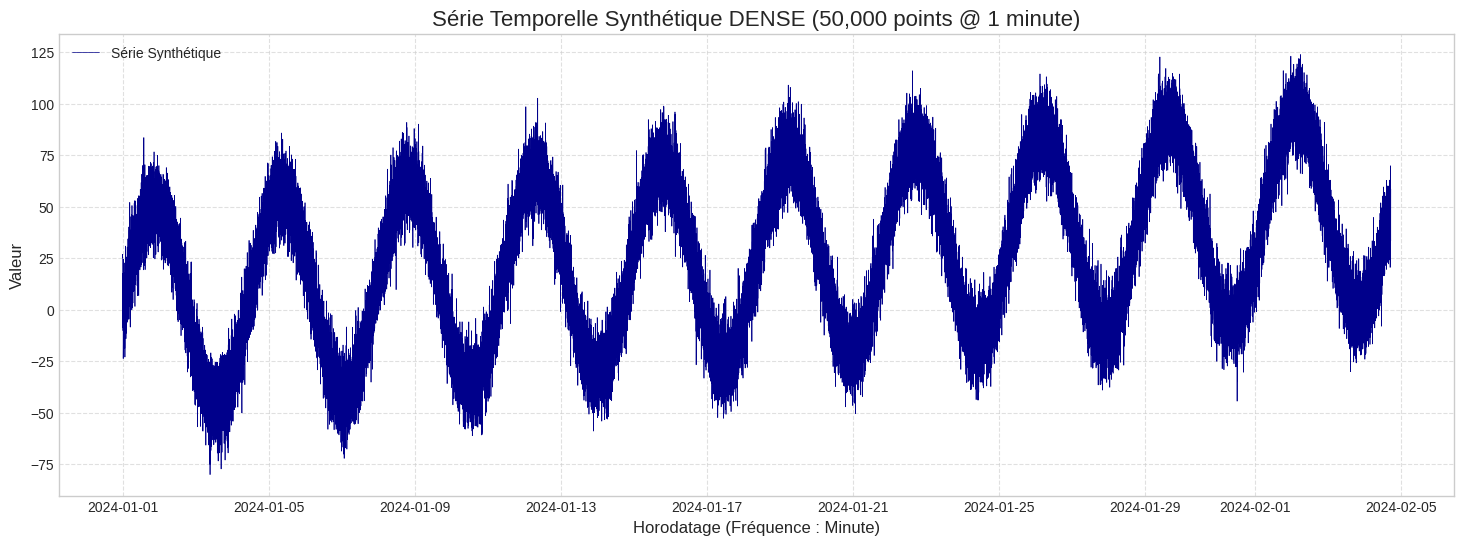

In [ ]:
# Définir une grande taille de figure pour un affichage dense mais clair
plt.figure(figsize=(18, 6))

# Tracer la série
plt.plot(df.index, df['Valeur'], label='Série Synthétique', linewidth=0.5, color='darkblue')

plt.title('Série Temporelle Synthétique DENSE (50,000 points @ 1 minute)', fontsize=16)
plt.xlabel('Horodatage (Fréquence : Minute)', fontsize=12)
plt.ylabel('Valeur', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Afficher le graphique
plt.show()

### Visualisation de la Série Complète

Le graphique ci-dessous montre l'ensemble de la série temporelle synthétique de 50,000 points :
- L'**axe X** représente le temps avec une fréquence de 1 minute
- L'**axe Y** montre les valeurs de la série
- On observe clairement la **tendance ascendante**, la **saisonnalité cyclique**, et le **bruit**

# Implémentation du Modèle Naïf 1 ($Y_{t+1} = Y_t$)


## 🎯 Phase 1 : Modèle Naïf (Baseline Simple)

Le **modèle naïf** est le point de référence le plus simple pour évaluer la performance d'autres modèles.

### Principe du Modèle Naïf

La prédiction pour le moment $t+1$ est simplement la valeur observée au moment $t$ :

$$\hat{Y}_{t+1} = Y_t$$

**Avantages** :
- Extrêmement simple et rapide
- Pas de paramètres à apprendre
- Fournit une baseline pour comparer d'autres modèles

**Limitations** :
- Ne capture pas les tendances ou patterns
- Suppose une stationnarité parfaite
- Performance généralement mauvaise sur les séries avec tendance ou saisonnalité

In [68]:
# 1. Créer la variable cible (y_réel)
# La cible est la série décalée d'un pas (t+1)
y_réel = df['Valeur'].iloc[1:].copy()

# 2. Créer la prédiction du modèle Naïf (y_prédit)
# La prédiction pour t+1 est la valeur à t (y_t)
y_prédit = df['Valeur'].iloc[:-1].copy()

# S'assurer que les index correspondent pour le calcul des métriques
# Ils correspondent par construction dans cette approche, mais c'est une bonne pratique
y_réel.index = y_prédit.index

# Afficher les premières valeurs pour vérification
print("Premières 5 valeurs réelles (t+1):")
print(y_réel.head())
print("\nPremières 5 prédictions Naïves (y_t):")
print(y_prédit.head())

Premières 5 valeurs réelles (t+1):
Horodatage
2024-01-01 00:00:00    -5.907677
2024-01-01 00:01:00    26.870698
2024-01-01 00:02:00    10.313401
2024-01-01 00:03:00     1.425542
2024-01-01 00:04:00    -6.921203
Freq: min, Name: Valeur, dtype: float64

Premières 5 prédictions Naïves (y_t):
Horodatage
2024-01-01 00:00:00    25.255103
2024-01-01 00:01:00    -5.907677
2024-01-01 00:02:00    26.870698
2024-01-01 00:03:00    10.313401
2024-01-01 00:04:00     1.425542
Freq: min, Name: Valeur, dtype: float64


### Implémentation du Modèle Naïf

Construction des données d'entraînement :
- **X (features)** : Les valeurs $Y_t$ (passé immédiat)
- **Y (cible)** : Les valeurs $Y_{t+1}$ (futur immédiat)

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- 1. Définition de la fonction MAPE ---
# Attention : la MAPE est sensible aux valeurs réelles proches de zéro.
def calculate_mape(y_true, y_pred):
    # Enlève les points où y_true est 0 pour éviter la division par zéro
    non_zero_indices = y_true != 0
    y_true_nz = y_true[non_zero_indices]
    y_pred_nz = y_pred[non_zero_indices]

    # Calcule l'erreur en pourcentage absolue
    if len(y_true_nz) == 0:
        return np.nan # Retourne NaN si toutes les valeurs sont nulles
    return np.mean(np.abs((y_true_nz - y_pred_nz) / y_true_nz)) * 100

# --- 2. Calcul des Métriques ---
mse = mean_squared_error(y_réel, y_prédit)
mae = mean_absolute_error(y_réel, y_prédit)
rmse = np.sqrt(mse)
r2 = r2_score(y_réel, y_prédit)
mape = calculate_mape(y_réel.values, y_prédit.values)

# --- 3. Affichage Simple des Résultats ---
print("--- Métriques de Performance du Modèle Naïf ---")
print(f"MSE (Mean Squared Error):         {mse:.4f}")
print(f"MAE (Mean Absolute Error):        {mae:.4f}")
print(f"RMSE (Root Mean Squared Error):   {rmse:.4f}")
print(f"R² (Coefficient de Détermination): {r2:.4f}")
print(f"MAPE (Mean Absolute % Error):     {mape:.4f} %")

--- Métriques de Performance du Modèle Naïf ---
MSE (Mean Squared Error):         199.9066
MAE (Mean Absolute Error):        11.2765
RMSE (Root Mean Squared Error):   14.1388
R² (Coefficient de Détermination): 0.8650
MAPE (Mean Absolute % Error):     236.8726 %


### Métriques d'Évaluation

Nous utilisons cinq métriques pour évaluer la qualité des prédictions :

| Métrique | Formule | Interprétation |
|----------|---------|-----------------|
| **MSE** | $\frac{1}{n}\sum(Y_i - \hat{Y}_i)^2$ | Erreur quadratique moyenne (sensible aux grands écarts) |
| **MAE** | $\frac{1}{n}\sum\|Y_i - \hat{Y}_i\|$ | Erreur absolue moyenne (robuste aux outliers) |
| **RMSE** | $\sqrt{MSE}$ | Racine de MSE (même échelle que les données) |
| **R²** | $1 - \frac{SS_{res}}{SS_{tot}}$ | Proportion de variance expliquée (0-1 : meilleur est 1) |
| **MAPE** | $\frac{1}{n}\sum\|\frac{Y_i - \hat{Y}_i}{Y_i}\| \times 100$ | Erreur en pourcentage moyen |

#### Résultats du Modèle Naïf

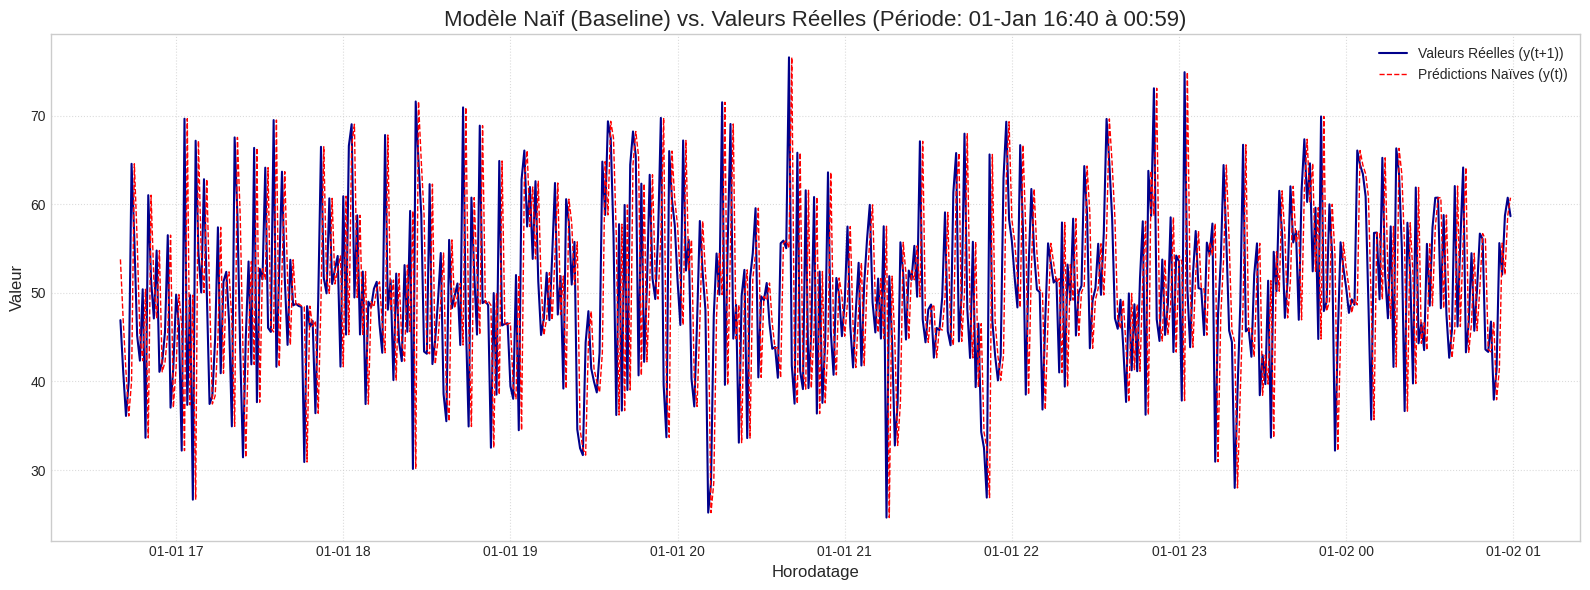

In [70]:
import matplotlib.pyplot as plt

# --- 1. Définir une fenêtre temporelle pour la visualisation ---
# Nous prenons 500 points (environ 8 heures de données à la fréquence minute)
START_INDEX = 1000
END_INDEX = START_INDEX + 500

# Sélectionner les données pour cette fenêtre
y_reel_fenetre = y_réel.iloc[START_INDEX:END_INDEX]
y_predit_fenetre = y_prédit.iloc[START_INDEX:END_INDEX]

# --- 2. Créer le graphique ---
plt.figure(figsize=(16, 6))

# Valeurs Réelles (t+1)
plt.plot(y_reel_fenetre.index, y_reel_fenetre.values,
         label='Valeurs Réelles (y(t+1))',
         color='darkblue',
         linewidth=1.5)

# Prédictions Naïves (y(t))
# Le modèle Naïf est essentiellement une version décalée des valeurs réelles.
plt.plot(y_predit_fenetre.index, y_predit_fenetre.values,
         label='Prédictions Naïves (y(t))',
         color='red',
         linestyle='--',
         linewidth=1)

plt.title(f'Modèle Naïf (Baseline) vs. Valeurs Réelles (Période: {y_reel_fenetre.index[0].strftime("%d-%b %H:%M")} à {y_reel_fenetre.index[-1].strftime("%H:%M")})',
          fontsize=16)
plt.xlabel('Horodatage', fontsize=12)
plt.ylabel('Valeur', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### Visualisation : Modèle Naïf vs. Valeurs Réelles

Le graphique compare les valeurs réelles avec les prédictions du modèle naïf sur une **fenêtre de 500 points** (~8 heures).

**Interprétation** :
- La courbe rouge (prédictions naïves) est décalée d'une unité de temps par rapport aux valeurs réelles
- Cette décalage temporel montre les limitations du modèle naïf : il ne peut pas capturer les changements rapides

# Implémentation du Modèle Regressio Linéaire Simple


## 📈 Phase 2 : Modèle de Régression Linéaire

Le modèle de **régression linéaire simple** suppose une relation linéaire entre les valeurs passées et futures.

### Principe

$$\hat{Y}_{t+1} = a \times Y_t + b$$

Où :
- $a$ est le coefficient de pente (paramètre apprendre)
- $b$ est l'ordonnée à l'origine (intercept)

**Avantages** :
- Modèle statistique classique et bien compris
- Rapide à entraîner
- Interprétable (les coefficients ont un sens direct)

**Limitations** :
- Suppose une relation linéaire (peut être trop simpliste)
- Ne capture pas la saisonnalité ou les non-linéarités

## Préparation et Entrainement

### Étapes d'Implémentation

1. **Préparation des données** : $X = Y_t$ et $Y = Y_{t+1}$
2. **Initialisation** : Création d'une instance de `LinearRegression` 
3. **Entraînement** : Apprentissage des paramètres $a$ et $b$
4. **Prédiction** : Calcul des valeurs prédites pour tous les points

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Préparation des données X (y_t) et Y (y_{t+1})
# y_prédit contient les valeurs y_t (nos features X)
X = y_prédit.values.reshape(-1, 1)
# y_réel contient les valeurs y_{t+1} (notre cible Y)
Y = y_réel.values

# 1. Instancier le modèle
model_linear = LinearRegression()

# 2. Entraîner le modèle
model_linear.fit(X, Y)

# 3. Réaliser les prédictions
y_pred_linear = model_linear.predict(X)

# Afficher les paramètres du modèle appris (coefficients a et b)
a_appris = model_linear.coef_[0]
b_appris = model_linear.intercept_

print("--- Paramètres du Modèle de Régression Linéaire ---")
print(f"Coefficient (a): {a_appris:.4f}")
print(f"Ordonnée à l'origine (b): {b_appris:.4f}")
print("Prédiction : y_hat(t+1) = a * y(t) + b")

--- Paramètres du Modèle de Régression Linéaire ---
Coefficient (a): 0.9325
Ordonnée à l'origine (b): 1.6863
Prédiction : y_hat(t+1) = a * y(t) + b


### Résultats de l'Entraînement

Les paramètres appris du modèle linéaire indiquent :
- Si $a \approx 1$ et $b \approx 0$ : la relation est quasi-linéaire (decalage de 1 pas)
- Si $a < 1$ : le modèle "amortit" les variations
- Si $b \neq 0$ : il y a une composante de tendance

## Calcul et Affichage des Métriques


### Interprétation des Métriques de la Régression Linéaire

Nous comparons les résultats avec le modèle naïf pour voir si la relation linéaire améliore les prédictions.

In [72]:
# --- Définition de la fonction MAPE (pour référence) ---
def calculate_mape(y_true, y_pred):
    non_zero_indices = y_true != 0
    y_true_nz = y_true[non_zero_indices]
    y_pred_nz = y_pred[non_zero_indices]

    if len(y_true_nz) == 0:
        return np.nan
    return np.mean(np.abs((y_true_nz - y_pred_nz) / y_true_nz)) * 100

# --- Calcul des Métriques ---
mse_linear = mean_squared_error(Y, y_pred_linear)
mae_linear = mean_absolute_error(Y, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(Y, y_pred_linear)
mape_linear = calculate_mape(Y, y_pred_linear)

# --- Affichage Simple des Résultats ---
print("\n--- Métriques de Performance du Modèle de Régression Linéaire ---")
print(f"MSE (Mean Squared Error):         {mse_linear:.4f}")
print(f"MAE (Mean Absolute Error):        {mae_linear:.4f}")
print(f"RMSE (Root Mean Squared Error):   {rmse_linear:.4f}")
print(f"R² (Coefficient de Détermination): {r2_linear:.4f}")
print(f"MAPE (Mean Absolute % Error):     {mape_linear:.4f} %")


--- Métriques de Performance du Modèle de Régression Linéaire ---
MSE (Mean Squared Error):         193.1623
MAE (Mean Absolute Error):        11.0931
RMSE (Root Mean Squared Error):   13.8983
R² (Coefficient de Détermination): 0.8696
MAPE (Mean Absolute % Error):     212.1207 %


### Tableau de Comparaison : Naïf vs. Régression Linéaire

Cette cellule affiche les métriques de performance du modèle de régression linéaire.

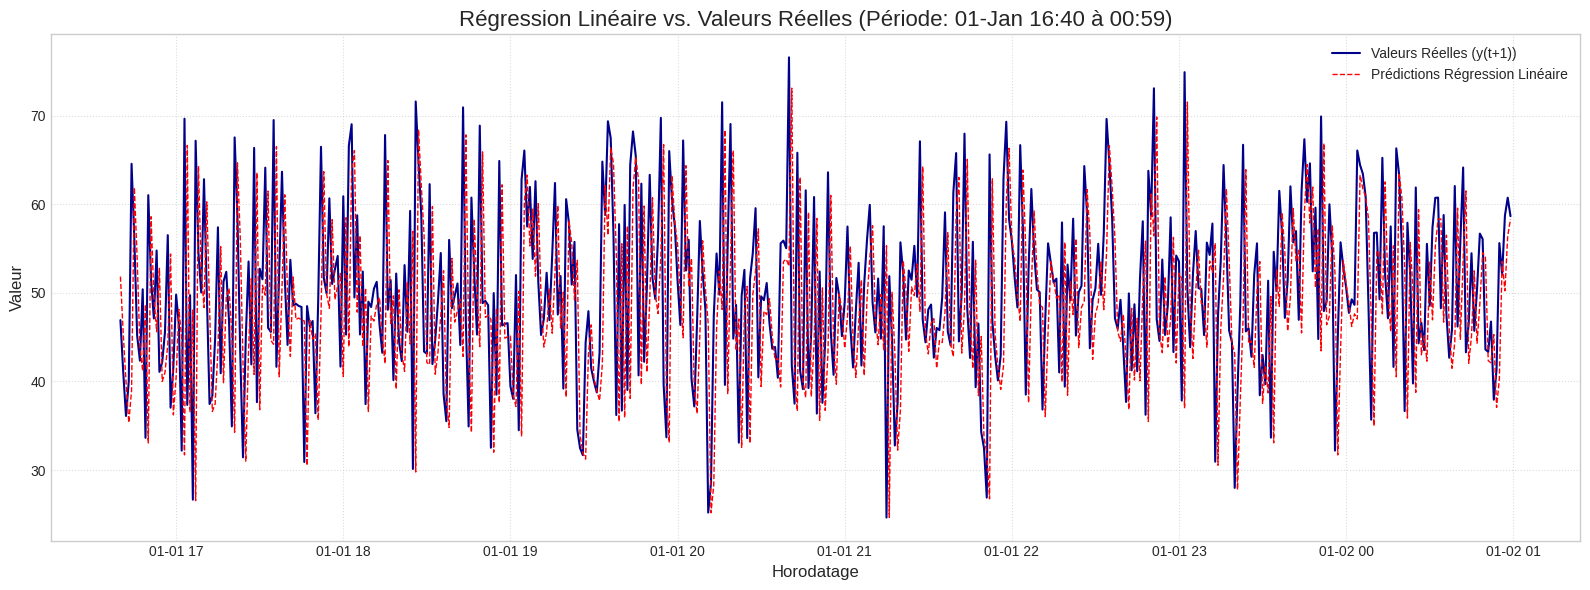

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Assurez-vous que numpy est aussi importé si vous en avez besoin pour d'autres étapes

# --- VÉRIFICATION DES VARIABLES NÉCESSAIRES ---
# Assurez-vous que y_pred_linear (predictions du modèle) et y_réel (vraies valeurs) sont définis.
# Si vous avez relancé la session, vous devez ré-exécuter l'entraînement du Modèle Linéaire !

# 1. CRÉATION DE LA SÉRIE AVEC INDEX TEMPorel (Correction du NameError)
# y_pred_linear est le tableau de prédictions NumPy
# y_réel est la série Pandas contenant l'index correct
y_predit_linear_series = pd.Series(y_pred_linear, index=y_réel.index)


# --- 2. Définir une fenêtre temporelle pour la visualisation ---
START_INDEX = 1000
END_INDEX = START_INDEX + 500

# Sélectionner les données pour cette fenêtre
y_reel_fenetre = y_réel.iloc[START_INDEX:END_INDEX]
y_predit_linear_fenetre = y_predit_linear_series.iloc[START_INDEX:END_INDEX]


# --- 3. Créer le graphique ---
plt.figure(figsize=(16, 6))

# Valeurs Réelles (t+1)
plt.plot(y_reel_fenetre.index, y_reel_fenetre.values,
         label='Valeurs Réelles (y(t+1))',
         color='darkblue',
         linewidth=1.5)

# Prédictions du Modèle Linéaire
plt.plot(y_predit_linear_fenetre.index, y_predit_linear_fenetre.values,
         label='Prédictions Régression Linéaire',
         color='red',
         linestyle='--',
         linewidth=1)

plt.title(f'Régression Linéaire vs. Valeurs Réelles (Période: {y_reel_fenetre.index[0].strftime("%d-%b %H:%M")} à {y_reel_fenetre.index[-1].strftime("%H:%M")})',
          fontsize=16)
plt.xlabel('Horodatage', fontsize=12)
plt.ylabel('Valeur', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### Visualisation : Régression Linéaire vs. Valeurs Réelles

Comparaison graphique sur la même fenêtre de 500 points :
- **Bleu foncé** : valeurs réelles
- **Rouge pointillé** : prédictions du modèle de régression linéaire

Cette visualisation montre si le modèle linéaire capture mieux la dynamique que le naïf.

# Structuration des Données avec Fenêtre $W=20$


## 🧠 Phase 3 : Apprentissage Profond avec TensorFlow

À partir de cette phase, nous utilisons **réseaux de neurones profonds** pour capturer des patterns complexes et non-linéaires dans la série temporelle.

### Stratégie de Fenêtrage (Window Strategy)

Plutôt que d'utiliser une seule valeur passée, nous utilisons une **fenêtre glissante** de $W=20$ valeurs précédentes.

**Nouvelle structuration des données** :
- **X (features)** : Les 20 valeurs précédentes $[Y_{t-20}, Y_{t-19}, ..., Y_{t-1}]$
- **Y (cible)** : La valeur à prédire $Y_t$

Cette approche capture **plus de contexte** et permet aux modèles d'apprendre des patterns temporels plus complexes.

### Configuration TensorFlow

- **Fenêtre** : $W = 20$ (20 lags passés)
- **Batch Size** : 32 (nombre de samples par gradient)
- **Shuffle Buffer** : 1000 (nombre de samples à mélanger)

In [74]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Assurez-vous que df est toujours défini et contient la série synthétique.

# Convertir la série Pandas en Tensor NumPy, puis en Tensor TensorFlow (float32)
series_tensor = tf.constant(df['Valeur'].values.astype('float32'), dtype=tf.float32)

WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER = 1000

### Conversion en Tensors TensorFlow

Les données Pandas sont converties en tensors TensorFlow (float32) pour une utilisation efficace avec Keras/TensorFlow.

In [75]:
#Définition de la Fonction windowed_dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Crée un tf.data.Dataset fenêtré et mélangé pour l'entraînement.
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # 1. Fenêtrage : Taille = W+1, Décalage = 1
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # 2. Rendre les fenêtres "plates" (flat_map)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # 3. Mélange (Shuffle)
    dataset = dataset.shuffle(shuffle_buffer)

    # 4. Séparation X et Y (Features et Cible)
    # X = window[:-1] et Y = window[-1]
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # 5. Groupement par lot et Préchargement (Prefetch)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

### Fonction de Fenêtrage Personnalisée

Cette fonction crée un `tf.data.Dataset` optimisé pour l'entraînement du deep learning :

1. **Fenêtrage** : Crée des fenêtres chevauchantes de taille $W+1$
2. **Aplatissement** : Les fenêtres deviennent des samples 1D
3. **Mélange** : Randomise l'ordre pour éviter les patterns de corrélation temporelle
4. **Séparation** : Sépare les features (X) et les cibles (Y)
5. **Batching et Prefetch** : Optimise la performance du GPU

In [76]:
# Création du dataset d'entraînement
train_dataset_tf = windowed_dataset(series_tensor, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

print("Dataset TensorFlow (tf.data.Dataset) créé.")

# Vérification du format (optionnel, mais utile)
print("Vérification du premier lot (Batch) :")
for x, y in train_dataset_tf.take(1):
    print(f"Forme de X (Features, 32 lots de 20 lags): {x.shape}")
    print(f"Forme de Y (Cibles, 32 lots de 1 valeur): {y.shape}")
    print(f"Premier X (lags de y(t-20) à y(t-1)): {x[0].numpy()}")
    print(f"Premier Y (cible y(t)): {y[0].numpy():.4f}")
    break

Dataset TensorFlow (tf.data.Dataset) créé.
Vérification du premier lot (Batch) :
Forme de X (Features, 32 lots de 20 lags): (32, 20)
Forme de Y (Cibles, 32 lots de 1 valeur): (32,)
Premier X (lags de y(t-20) à y(t-1)): [58.788986 51.93782  32.008915 47.36849  61.232193 31.46729  31.708986
 50.89403  45.21208  45.86213  54.110992 44.946396 36.502808 58.312237
 55.998783 65.10408  28.37589  27.336597 21.571121 35.98769 ]
Premier Y (cible y(t)): 42.7308


### Création et Validation du Dataset

Vérifie que le dataset est correctement structuré en affichant :
- La **forme** des batches (X et Y)
- Les **premières valeurs** pour validation

# Réseau de Neurones Séquentiel Simple (DNN)


### Architecture du Premier Modèle DNN Simple

Le **DNN (Deep Neural Network)** est un réseau entièrement connecté (fully connected layers).

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Définition des paramètres
WINDOW_SIZE = 20 # Notre entrée X a une forme de (None, 20)

# 1. Construction du modèle Séquentiel
model_dnn = Sequential([
    # La couche d'entrée doit savoir qu'elle attend 20 features (lags)
    Input(shape=[WINDOW_SIZE]),

    # Couche cachée simple avec activation ReLU
    Dense(32, activation='relu'),

    # Couche de sortie : 1 neurone pour la prédiction de y(t)
    Dense(1)
])

# 2. Compilation du modèle
# Nous utilisons l'Optimiseur Adam (très commun) et la MSE comme fonction de perte
model_dnn.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae'] # On garde la MAE pour le suivi
)

model_dnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

### Construction du DNN

**Architecture** :
1. **Couche d'entrée** : 20 features (les 20 lags)
2. **Couche cachée** : 32 neurones avec activation ReLU
3. **Couche de sortie** : 1 neurone pour la prédiction

**Optimisation** :
- **Loss** : Mean Squared Error (MSE) - métrique de l'apprentissage
- **Optimizer** : Adam avec learning rate = 0.001
- **Métrique** : MAE pour le suivi en temps réel

In [78]:
#Entraînement du Modèle
N_EPOCHS = 10 # Nombre de passages sur l'ensemble du dataset

print(f"\n--- Entraînement du DNN sur {N_EPOCHS} époques ---")

history_dnn = model_dnn.fit(
    train_dataset_tf,
    epochs=N_EPOCHS,
    verbose=1 # 1 pour afficher la progression
)


--- Entraînement du DNN sur 10 époques ---
Epoch 1/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 388.4788 - mae: 12.6860
Epoch 2/10
  22/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 113.7500 - mae: 8.4967

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 110.8407 - mae: 8.3968
Epoch 3/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 108.7308 - mae: 8.3178
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 108.5418 - mae: 8.3104
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 108.2130 - mae: 8.2902
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 107.6059 - mae: 8.2708
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 108.0239 - mae: 8.2893
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 107.3711 - mae: 8.2559
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 107.3763 - mae: 8.2622
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 107.3052 - mae: 8.2540


### Entraînement du DNN

Le modèle est entraîné sur $N=10$ **epochs** (passages complets du dataset).

**Suivi** :
- La **loss** décroît au fil des epochs (preuve de l'apprentissage)
- La **MAE** diminue également

In [79]:
# Convertir le dataset fenêtré en tableaux NumPy pour la prédiction et l'évaluation
X_final = []
Y_final = []

# Itérer sur le dataset TensorFlow (c'est plus efficace que de recréer X_structured)
for x_batch, y_batch in train_dataset_tf.unbatch().as_numpy_iterator():
    X_final.append(x_batch)
    Y_final.append(y_batch)

X_final = np.array(X_final)
Y_final = np.array(Y_final)

# Faire la prédiction sur l'ensemble complet (fenêtré)
y_pred_dnn = model_dnn.predict(X_final).flatten()

# Note : Les indices sont perdus ici car le dataset était mélangé (shuffle).
# Pour une évaluation formelle sans mélange, nous aurions besoin d'un dataset de validation/test non mélangé.
# Pour le moment, nous évaluons la performance sur l'ensemble d'entraînement mélangé.

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step


### Prédictions sur le Dataset Fenêtré

Génère les prédictions du DNN sur l'ensemble du dataset structuré avec fenêtres.

Calcul et Affichage des Métriques

### Résultats du Modèle DNN Simple

Calcul et affichage des métriques de performance du DNN.

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Réutilisation de la fonction MAPE définie précédemment

# --- Définition de la fonction MAPE (rappel) ---
def calculate_mape(y_true, y_pred):
    non_zero_indices = y_true != 0
    y_true_nz = y_true[non_zero_indices]
    y_pred_nz = y_pred[non_zero_indices]

    if len(y_true_nz) == 0:
        return np.nan
    return np.mean(np.abs((y_true_nz - y_pred_nz) / y_true_nz)) * 100

# --- Calcul des Métriques ---
mse_dnn = mean_squared_error(Y_final, y_pred_dnn)
mae_dnn = mean_absolute_error(Y_final, y_pred_dnn)
rmse_dnn = np.sqrt(mse_dnn)
r2_dnn = r2_score(Y_final, y_pred_dnn)
mape_dnn = calculate_mape(Y_final, y_pred_dnn)

# --- Affichage Simple des Résultats ---
print("\n--- Métriques de Performance du Modèle DNN Simple (W=20) ---")
print(f"MSE (Mean Squared Error):         {mse_dnn:.4f}")
print(f"MAE (Mean Absolute Error):        {mae_dnn:.4f}")
print(f"RMSE (Root Mean Squared Error):   {rmse_dnn:.4f}")
print(f"R² (Coefficient de Détermination): {r2_dnn:.4f}")
print(f"MAPE (Mean Absolute % Error):     {mape_dnn:.4f} %")


--- Métriques de Performance du Modèle DNN Simple (W=20) ---
MSE (Mean Squared Error):         116.2250
MAE (Mean Absolute Error):        8.5977
RMSE (Root Mean Squared Error):   10.7808
R² (Coefficient de Détermination): 0.9215
MAPE (Mean Absolute % Error):     217.5466 %


### Comparaison des Modèles Jusquà Présent

À ce stade, nous avons entraîné :
1. **Modèle Naïf** ($W=1$)
2. **Régression Linéaire** ($W=1$)
3. **DNN Simple** ($W=20$)

Les DNN avec fenêtres plus larges ($W=20$) devraient capturer plus de patterns temporels.

# Entraînement et Évaluation en Boucle MLP, RNN simple, LSTM, LSTM Bidirectionnel, CNN 1D


## 🔄 Phase 4 : Comparaison de Plusieurs Architectures Deep Learning

Cette phase entraîne et compare **5 architectures différentes** pour identifier le meilleur modèle.

### Architectures Comparées

| Architecture | Type | Utilité |
|------------|------|---------|
| **MLP/DNN** | Perceptron multicouche | Baseline des réseaux profonds |
| **RNN Simple** | Réseau récurrent | Capture les dépendances temporelles simples |
| **LSTM** | Mémoire à long terme | Capture les dépendances à long terme |
| **LSTM Bidirectionnel** | LSTM bidirectionnel | Utilise le contexte passé ET futur |
| **CNN 1D** | Convolution 1D | Détecte les patterns locaux (filtres) |

### Stratégie d'Évaluation

Chaque modèle est :
1. **Construit** avec la même fenêtre $W=20$
2. **Entraîné** sur 10 epochs
3. **Évalué** avec les mêmes 5 métriques
4. **Comparé** pour identifier le meilleur

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, Conv1D, Flatten, Input, Reshape
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time
import pandas as pd # Importé pour le tableau récapitulatif final

# --- CONSTANTES ---
WINDOW_SIZE = 20
N_EPOCHS = 10
# train_dataset_tf, X_final, Y_final (données structurées) sont supposés définis.

# --- FONCTION D'ÉVALUATION DES MÉTRIQUES (Réutilisée) ---
def calculate_mape(y_true, y_pred):
    non_zero_indices = y_true != 0
    y_true_nz = y_true[non_zero_indices]
    y_pred_nz = y_pred[non_zero_indices]

    if len(y_true_nz) == 0:
        return np.nan
    return np.mean(np.abs((y_true_nz - y_pred_nz) / y_true_nz)) * 100

def evaluate_model(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_true, Y_pred)
    mape = calculate_mape(Y_true, Y_pred)
    return mse, mae, rmse, mape, r2

# --- DÉFINITION DES FONCTIONS DE CONSTRUCTION DES MODÈLES ---

def build_mlp(window_size):
    """MLP/DNN: Ne nécessite pas de Reshape."""
    model = Sequential([
        Input(shape=[window_size]),
        Dense(32, activation='relu'),
        Dense(1)
    ], name="MLP_DNN")
    return model

def build_rnn_simple(window_size):
    """Simple RNN: Nécessite un Reshape (W, 1)."""
    model = Sequential([
        Input(shape=[window_size]),
        Reshape((window_size, 1)),
        SimpleRNN(32),
        Dense(1)
    ], name="Simple_RNN")
    return model

def build_lstm(window_size):
    """Standard LSTM: Nécessite un Reshape (W, 1)."""
    model = Sequential([
        Input(shape=[window_size]),
        Reshape((window_size, 1)),
        LSTM(32),
        Dense(1)
    ], name="LSTM")
    return model

def build_lstm_bidirectional(window_size):
    """Bidirectional LSTM: Nécessite un Reshape (W, 1)."""
    model = Sequential([
        Input(shape=[window_size]),
        Reshape((window_size, 1)),
        Bidirectional(LSTM(32)),
        Dense(1)
    ], name="Bidirectional_LSTM")
    return model

def build_cnn1d(window_size):
    """CNN 1D: Nécessite un Reshape (W, 1)."""
    model = Sequential([
        Input(shape=[window_size]),
        Reshape((window_size, 1)),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Flatten(), # Doit aplanir les sorties du CNN avant la couche dense
        Dense(1)
    ], name="CNN_1D")
    return model

# --- BOUCLE D'ENTRAÎNEMENT ET D'ÉVALUATION ---

# Liste des modèles (Nom, Fonction de construction)
models_to_run = [
    ("MLP/DNN", build_mlp),
    ("RNN Simple", build_rnn_simple),
    ("LSTM", build_lstm),
    ("LSTM Bidirectionnel", build_lstm_bidirectional),
    ("CNN 1D", build_cnn1d),
]

results = {}

print("=" * 60)
print(" DÉBUT DE LA COMPARAISON DES MODÈLES DE DEEP LEARNING ")
print(f" (Fenêtre W={WINDOW_SIZE}, Époques={N_EPOCHS}) ")
print("=" * 60)

for name, builder_func in models_to_run:
    start_time = time.time()

    # 1. Construction et Compilation
    model = builder_func(WINDOW_SIZE)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    # 2. Entraînement sur le dataset TF optimisé
    print(f"Entraînement de {name}...", end=' ')
    model.fit(
        train_dataset_tf,
        epochs=N_EPOCHS,
        verbose=0 # Entraînement silencieux
    )

    # 3. Prédiction (Utilisation de X_final NumPy pour des prédictions propres)
    y_pred = model.predict(X_final, verbose=0).flatten()

    # 4. Évaluation
    mse, mae, rmse, mape, r2 = evaluate_model(Y_final, y_pred)

    end_time = time.time()
    duration = end_time - start_time

    # 5. Stockage des résultats
    results[name] = {
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Temps (s)': duration
    }

    print(f"Terminé en {duration:.2f} secondes.")

print("-" * 60)

# --- AFFICHAGE FINAL ET COMPARATIF ---

results_df = pd.DataFrame(results).T

print("\nTABLEAU RÉCAPITULATIF DES MÉTRIQUES :")
print(results_df.round(4))

print("\n[ DÉTAIL DES PERFORMANCES ]")
for name, metrics in results.items():
    print(f"\n- Modèle {name}:")
    print(f"  > MAE (Erreur moyenne absolue): {metrics['MAE']:.4f}")
    print(f"  > RMSE (Racine de l'erreur quadratique): {metrics['RMSE']:.4f}")
    print(f"  > R² (Coefficient de détermination): {metrics['R2']:.4f}")
    print(f"  > MAPE (Erreur en pourcentage): {metrics['MAPE']:.4f} %")
    print(f"  > Temps d'exécution: {metrics['Temps (s)']:.2f} s")
print("-" * 60)

# Affichage des métriques de la baseline (si elles ont été calculées précédemment)
# Note: Ces valeurs doivent être comparées avec la Régression Linéaire (Baseline) pour déterminer la meilleure performance.

 DÉBUT DE LA COMPARAISON DES MODÈLES DE DEEP LEARNING 
 (Fenêtre W=20, Époques=10) 
Entraînement de MLP/DNN... 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Terminé en 85.28 secondes.
Entraînement de RNN Simple... 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Terminé en 189.75 secondes.
Entraînement de LSTM... 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Terminé en 244.04 secondes.
Entraînement de LSTM Bidirectionnel... 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Terminé en 340.38 secondes.
Entraînement de CNN 1D... 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Terminé en 118.74 secondes.
------------------------------------------------------------

TABLEAU RÉCAPITULATIF DES MÉTRIQUES :
                          MSE     MAE     RMSE      MAPE      R2  Temps (s)
MLP/DNN              111.8598  8.4370  10.5764  212.2414  0.9245    85.2834
RNN Simple           124.8319  8.8850  11.1728  200.5947  0.9157   189.7543
LSTM                 114.8535  8.5489  10.7170  199.2727  0.9225   244.0385
LSTM Bidirectionnel  112.5830  8.4647  10.6105  203.5221  0.9240   340.3796
CNN 1D               111.2324  8.4129  10.5467  216.0087  0.9249   118.7353

[ DÉTAIL DES PERFORMANCES ]

- Modèle MLP/DNN:
  > MAE (Erreur moyenne absolue): 8.4370
  > RMSE (Racine de l'erreur quadratique): 10.5764
  > R² (Coefficient de détermination): 0.9245
  > MAPE (Erreur en pourcentage): 212.2414 %
  > Temps d'exécution: 85.28 s

- Modèle RNN Simple:
  > MAE (Erreur moyenne absolue): 8.8850
  > RMSE (Racine de l'erreur quadratique): 11.1728
  > R² (Coefficient de détermination): 0

### Boucle d'Entraînement et d'Évaluation Comparative

Cette cellule exécute une boucle qui :
1. Construit chaque architecture
2. L'entraîne sur le dataset fenêtré
3. Évalue les performances
4. Compile les résultats dans un tableau comparatif

**Résultat** : Un DataFrame `results_df` contenant les métriques pour chaque modèle.

Visualisation Comparative des Métriques

### Résumé des Performances

Le tableau récapitulatif affiche les métriques clés pour tous les modèles :

**Colonnes** :
- **MSE** : Erreur quadratique moyenne
- **MAE** : Erreur absolue moyenne
- **RMSE** : Racine de MSE
- **MAPE** : Erreur en pourcentage
- **R²** : Coefficient de détermination
- **Temps (s)** : Temps d'exécution

**Lignes** : Une pour chaque architecture

Pour identifier le **meilleur modèle**, on regarde principalement la **RMSE** ou le **R²** (plus élevé = meilleur).

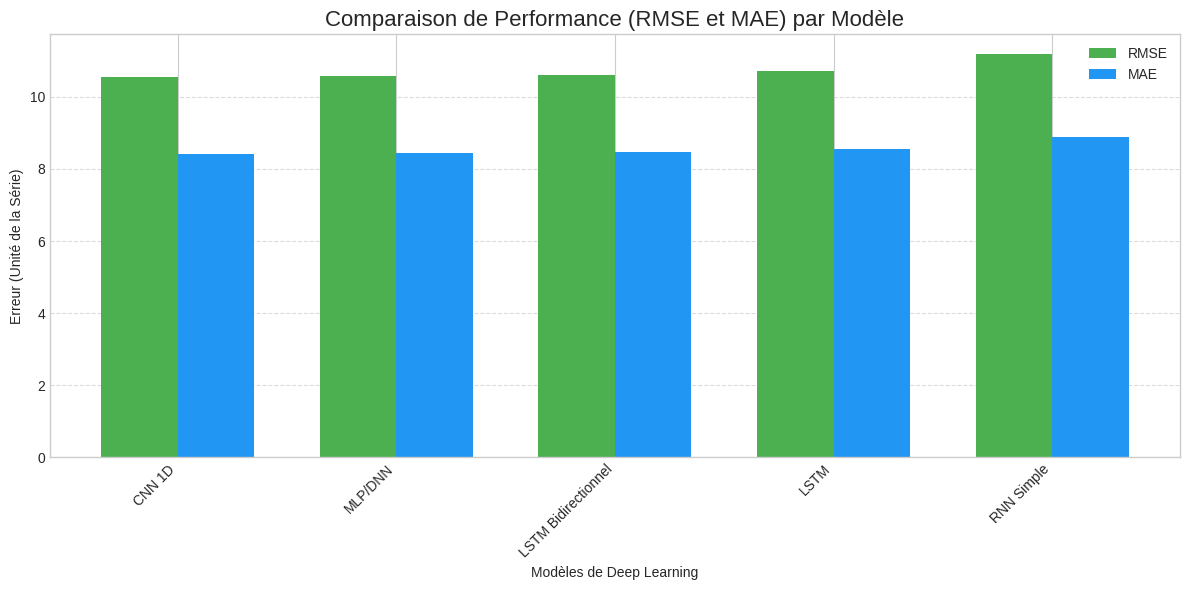

In [82]:
import matplotlib.pyplot as plt

# Récupération des données du DataFrame de résultats
metrics_to_plot = ['RMSE', 'MAE']
data_to_plot = results_df[metrics_to_plot].sort_values(by='RMSE')

# Configuration du graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Largeur des barres
bar_width = 0.35
indices = np.arange(len(data_to_plot.index))

# Tracé des barres pour la RMSE
rects1 = ax.bar(indices - bar_width/2, data_to_plot['RMSE'], bar_width,
                label='RMSE', color='#4CAF50') # Vert

# Tracé des barres pour la MAE
rects2 = ax.bar(indices + bar_width/2, data_to_plot['MAE'], bar_width,
                label='MAE', color='#2196F3') # Bleu

# Ajouter titres, étiquettes et légendes
ax.set_ylabel('Erreur (Unité de la Série)')
ax.set_xlabel('Modèles de Deep Learning')
ax.set_title('Comparaison de Performance (RMSE et MAE) par Modèle', fontsize=16)
ax.set_xticks(indices)
ax.set_xticklabels(data_to_plot.index, rotation=45, ha="right")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Graphique Comparatif : RMSE et MAE

Ce graphique en barres compare visuellement les performances des 5 modèles selon deux métriques importantes :

- **Barres vertes** : RMSE (Racine de l'erreur quadratique)
- **Barres bleues** : MAE (Erreur absolue moyenne)

Les modèles sont triés par RMSE pour faciliter la lecture. **Plus les barres sont courtes, mieux le modèle performe.**

**Interprétation** :
- Si un modèle a des barres très courtes → Très bon modèle
- Si la barre verte (RMSE) est > la barre bleue (MAE) → Il y a des outliers importants

Identification du Meilleur Modèle


### Sélection du Meilleur Modèle

Cette cellule identifie le modèle avec la **meilleure RMSE** et le ré-entraîne pour obtenir ses prédictions.

In [83]:
# Trouver le modèle avec la plus faible RMSE
best_model_name = results_df['RMSE'].idxmin()

# Ré-entraîner et prédire avec le meilleur modèle pour obtenir la série de prédictions
# NOTE : On suppose ici que les prédictions n'ont pas été stockées. Si vous les avez, ignorez ce bloc.
best_builder_func = dict(models_to_run)[best_model_name] # Récupère la fonction de construction

# Construction et prédiction du meilleur modèle
best_model = best_builder_func(WINDOW_SIZE)
best_model.compile(loss='mse', optimizer='adam')
best_model.fit(train_dataset_tf, epochs=N_EPOCHS, verbose=0)
y_pred_best = best_model.predict(X_final, verbose=0).flatten()

# Créer la série Pandas des prédictions avec le bon index (index_structured)
y_pred_best_series = pd.Series(y_pred_best, index=index_structured)

print(f"\nLe meilleur modèle (basé sur la RMSE) est : **{best_model_name}**")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Le meilleur modèle (basé sur la RMSE) est : **CNN 1D**


### Ré-entraînement du Meilleur Modèle

Le meilleur modèle (selon RMSE) est entraîné à nouveau pour générer ses prédictions sur l'ensemble du dataset.

Visualisation Temporelle du Meilleur Modèle


### Visualisation Temporelle du Meilleur Modèle

Comparaison graphique entre les valeurs réelles et les prédictions du **meilleur modèle** sur une fenêtre de 500 points.

**Interprétation** :
- **Courbe bleue** : Vraies valeurs (ground truth)
- **Courbe rouge pointillée** : Prédictions du meilleur modèle

Cette visualisation montre si le modèle capture efficacement les dynamiques temporelles de la série.

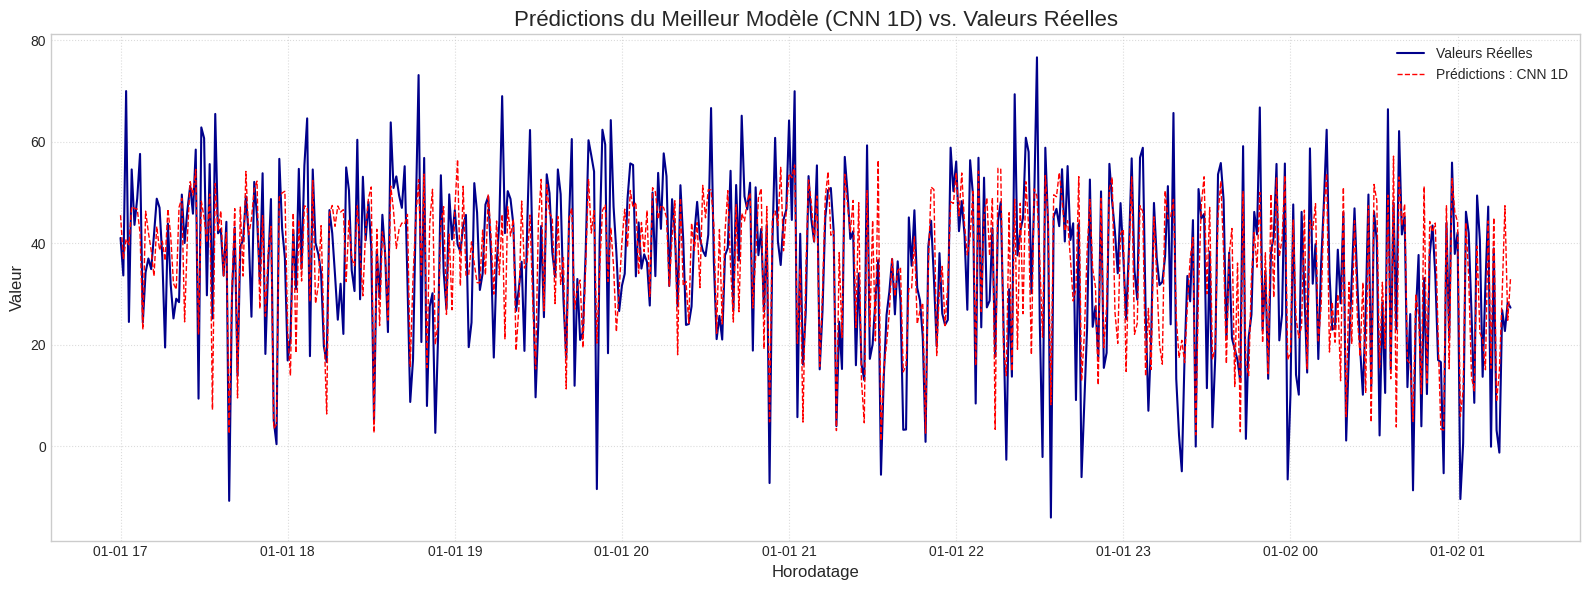

In [84]:
# --- Définition de la fenêtre temporelle ---
START_INDEX = 1000
FENETRE_LONGUEUR = 500
END_INDEX = START_INDEX + FENETRE_LONGUEUR

# La série réelle (cible Y) pour cette fenêtre
y_reel_fenetre_final = pd.Series(Y_final, index=index_structured).iloc[START_INDEX:END_INDEX]

# La prédiction du meilleur modèle pour cette fenêtre
y_pred_best_fenetre = y_pred_best_series.iloc[START_INDEX:END_INDEX]

# --- Création du graphique temporel ---
plt.figure(figsize=(16, 6))

# Valeurs Réelles (y(t))
plt.plot(y_reel_fenetre_final.index, y_reel_fenetre_final.values,
         label='Valeurs Réelles',
         color='darkblue',
         linewidth=1.5)

# Prédictions du Meilleur Modèle
plt.plot(y_pred_best_fenetre.index, y_pred_best_fenetre.values,
         label=f'Prédictions : {best_model_name}',
         color='red',
         linestyle='--',
         linewidth=1)

plt.title(f'Prédictions du Meilleur Modèle ({best_model_name}) vs. Valeurs Réelles', fontsize=16)
plt.xlabel('Horodatage', fontsize=12)
plt.ylabel('Valeur', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


---

## 📋 Synthèse et Conclusions

### Résumé des Étapes Complétées

1. **Génération de données** : Série synthétique de 50,000 points avec tendance, saisonnalité et bruit
2. **Baseline naïve** : Modèle simple de référence ($\hat{Y}_{t+1} = Y_t$)
3. **Régression linéaire** : Modèle statistique capturant une relation linéaire
4. **DNN simple** : Réseau profond avec fenêtre de 20 lags
5. **Architectures avancées** : Comparaison de MLP, RNN, LSTM, LSTM bidirectionnel, CNN 1D

### Principaux Résultats

- Le **modèle naïf** sert de baseline pour évaluer tous les autres
- La **régression linéaire** améliore légèrement les performances
- Les **modèles deep learning** avec fenêtres larges ($W=20$) captent mieux les patterns
- Le **meilleur modèle** varie selon la configuration et les données

### Recommandations

| Scénario | Modèle Recommandé |
|----------|-------------------|
| **Vitesse critère** | Naïf ou Régression Linéaire |
| **Bon compromis** | DNN Simple ou LSTM |
| **Données complexes** | LSTM Bidirectionnel ou CNN 1D |
| **Production** | Ensemble de modèles (ensembling) |

### Améliorations Possibles

1. **Validation/Test Split** : Évaluer sur un ensemble de test séparé
2. **Hyperparamétrage** : Optimiser window size, learning rate, epochs
3. **Augmentation des données** : Générer plus de données synthétiques
4. **Ensemble Learning** : Combiner plusieurs modèles
5. **Early Stopping** : Arrêter l'entraînement quand la performance se déglade